# Problem Formulation

- 1 of the objectives of social media marketers are to maximise user engagement in order to gain leads for businesses
- Problem: They do not have an informed way to determine what to post in order maximise their chances of user engagement. There are existing platforms that claim to do this, but they are not accurate.

# Objective

- Come up with a model to give marketers a prediction on the share rate for a given post.
    - Share rate is measured by: (number of shares) / (unique impressions)
- Attributes to be taken in consideration for the post are:
    - Which weekday the post is 
    - Time of the post
    - length of text (character count)
    - Format of post (video, photo, album, etc)
    - Whether the post is for a contest
    - Amplification: (Paid / Organic)
    - Time from the last post
    - Number of creatives (Photos, and videos, etc)
    
    


# Considerations

What influences engagement level might differ across different domains. We will try to build a model for a single domain for now.

# Data plan

#### Input Source:
- Facebook API (The Faceshop)


#### Cleaning
- We will need to hand-label: 
    - Whether the post is for a contest
    
#### Extract
- We will need to extract and fill in programmatically:
    - Time from the last post
    - Which weekday the post is
    - Time of the post
    - length of text (character count)
    - The share rate



# Feature Extraction Plan

- Explore correlations within the data and decide which features are important
- Ensure classes are well represented across the dataset

# Evaluation Methods

- We will use MAE because the inherently small numbers for share rate

# Proposed Methods

This is a regression problem; we will try to use the following models:
- Linear Regression
- Polynomial Regression
- Neural network (MLP)
- Neural network with word embeddings

In [1587]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model  
from IPython.display import Image
import pickle


# Import Data

In [1588]:
df = pd.read_json('./posts.json')
df.head()

amplification  clicks  clicks_unique  comments        created_time  \
0          paid     696            538        10 2018-12-08 05:00:01   
1          paid     323            286         1 2018-12-07 09:00:01   
2          paid     459            301         6 2018-12-06 09:00:02   
3       organic      42             37         0 2018-12-05 11:12:12   
4       organic     507            315         4 2018-12-03 03:35:16   

   engagements            id  impressions  impressions_organic  \
0          801  1.038028e+30        12299                 9077   
1          313  1.038028e+30        16188                 4060   
2          362  1.038028e+30        10115                 2679   
3           53  1.038028e+30         4701                 4853   
4          346  1.038028e+30         9623                 9880   

   impressions_organic_unique   ...     promotion_amount  reactions_haha  \
0                        6601   ...                    0               4   
1                        2942   ...                    0               0   
2                        1961   ...                    0               0   
3                        3365   ...                    0               0   
4                        5196   ...                    0               0   

  reactions_like  reactions_love reactions_sorry  shares time  \
0            276              18               1      21   13   
1             29               2               0       3   17   
2             61               5               0      11   17   
3             15               1               0       0   19   
4             32               9               0      10   11   

                    type     visual_style  weekday  
0                  photo  photo_realistic        6  
1  video_direct_response  photo_realistic        5  
2           video_inline  photo_realistic        4  
3                  photo  photo_realistic        3  
4                  album  photo_realistic        1  

[5 rows x 31 columns]

In [1589]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 31 columns):
amplification                    708 non-null object
clicks                           708 non-null int64
clicks_unique                    708 non-null int64
comments                         708 non-null int64
created_time                     708 non-null datetime64[ns]
engagements                      708 non-null int64
id                               708 non-null float64
impressions                      708 non-null int64
impressions_organic              708 non-null int64
impressions_organic_unique       708 non-null int64
impressions_paid                 708 non-null int64
impressions_paid_unique          708 non-null int64
intent                           708 non-null object
is_contest                       708 non-null int64
is_sharing_required_for_promo    708 non-null object
last_post_time_diff              708 non-null int64
media_src_url                    708 non-null obj

# Data Cleaning

In [1590]:
#messages
df['message'] = df['message'].fillna('')

In [1591]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 31 columns):
amplification                    708 non-null object
clicks                           708 non-null int64
clicks_unique                    708 non-null int64
comments                         708 non-null int64
created_time                     708 non-null datetime64[ns]
engagements                      708 non-null int64
id                               708 non-null float64
impressions                      708 non-null int64
impressions_organic              708 non-null int64
impressions_organic_unique       708 non-null int64
impressions_paid                 708 non-null int64
impressions_paid_unique          708 non-null int64
intent                           708 non-null object
is_contest                       708 non-null int64
is_sharing_required_for_promo    708 non-null object
last_post_time_diff              708 non-null int64
media_src_url                    708 non-null obj

# Encoding

In [1592]:
cols_to_encode = ['amplification', 'intent', 'type']
encoders = {}

for i in range(0, len(cols_to_encode)):
    col = cols_to_encode[i]
    encoders[col] = LabelEncoder()
    df[col + '_encoded'] = encoders[col].fit_transform(df[col])


In [1593]:
df.head()

amplification  clicks  clicks_unique  comments        created_time  \
0          paid     696            538        10 2018-12-08 05:00:01   
1          paid     323            286         1 2018-12-07 09:00:01   
2          paid     459            301         6 2018-12-06 09:00:02   
3       organic      42             37         0 2018-12-05 11:12:12   
4       organic     507            315         4 2018-12-03 03:35:16   

   engagements            id  impressions  impressions_organic  \
0          801  1.038028e+30        12299                 9077   
1          313  1.038028e+30        16188                 4060   
2          362  1.038028e+30        10115                 2679   
3           53  1.038028e+30         4701                 4853   
4          346  1.038028e+30         9623                 9880   

   impressions_organic_unique      ...       reactions_love  reactions_sorry  \
0                        6601      ...                   18                1   
1                        2942      ...                    2                0   
2                        1961      ...                    5                0   
3                        3365      ...                    1                0   
4                        5196      ...                    9                0   

  shares  time                   type     visual_style weekday  \
0     21    13                  photo  photo_realistic       6   
1      3    17  video_direct_response  photo_realistic       5   
2     11    17           video_inline  photo_realistic       4   
3      0    19                  photo  photo_realistic       3   
4     10    11                  album  photo_realistic       1   

  amplification_encoded intent_encoded  type_encoded  
0                     1              0             6  
1                     1              0            10  
2                     1              0            11  
3                     0              0             6  
4                     0              0             0  

[5 rows x 34 columns]

# Calculate target - Share Rate

In [1594]:
epsilon = 1e-10
df['share_rate'] = df['shares'] / (df['impressions_organic_unique'] + df['impressions_paid_unique'] + epsilon) * 100

target = 'share_rate'

# Remove unwanted columns

In [1595]:
df.columns

Index(['amplification', 'clicks', 'clicks_unique', 'comments', 'created_time',
       'engagements', 'id', 'impressions', 'impressions_organic',
       'impressions_organic_unique', 'impressions_paid',
       'impressions_paid_unique', 'intent', 'is_contest',
       'is_sharing_required_for_promo', 'last_post_time_diff', 'media_src_url',
       'media_url', 'message', 'message_length', 'num_creatives',
       'promotion_amount', 'reactions_haha', 'reactions_like',
       'reactions_love', 'reactions_sorry', 'shares', 'time', 'type',
       'visual_style', 'weekday', 'amplification_encoded', 'intent_encoded',
       'type_encoded', 'share_rate'],
      dtype='object')

In [1596]:
try:
    df.drop([
        'amplification',
        'clicks', 'clicks_unique', 'comments', 'created_time', 'engagements', 
        'id', 'impressions', 'impressions_organic', 'impressions_organic_unique', 
        'impressions_paid', 'impressions_paid_unique', 
        'intent', 'is_sharing_required_for_promo', 'media_src_url', 'media_url', 
        'promotion_amount', 'reactions_haha', 'reactions_like', 'reactions_love', 
        'reactions_sorry', 'visual_style', 'intent_encoded'], axis=1, inplace=True)

except:
    pass


features = [
    'is_contest', 'last_post_time_diff',
    'message_length', 'num_creatives', 'shares', 
    'time', 'type_encoded', 'weekday', 'amplification_encoded',
    'type_encoded'
]

df.head()

is_contest  last_post_time_diff  \
0           0                72000   
1           0                86399   
2           0                78470   
3           0               200216   
4           0               403367   

                                             message  message_length  \
0  A gift that fits conveniently into your travel...             383   
1  Christmas shopping made easier with THEFACESHO...             280   
2  All you want for Christmas is THEFACESHOP x li...             259   
3  #WHATSNEW: Play up your look with the all-new ...             311   
4  This is what you have all been waiting for, TH...             271   

   num_creatives  shares  time                   type  weekday  \
0              1      21    13                  photo        6   
1              1       3    17  video_direct_response        5   
2              1      11    17           video_inline        4   
3              1       0    19                  photo        3   
4              4      10    11                  album        1   

   amplification_encoded  type_encoded  share_rate  
0                      1             6    0.129143  
1                      1            10    0.015949  
2                      1            11    0.127699  
3                      0             6    0.000000  
4                      0             0    0.192456

# Data Exploration

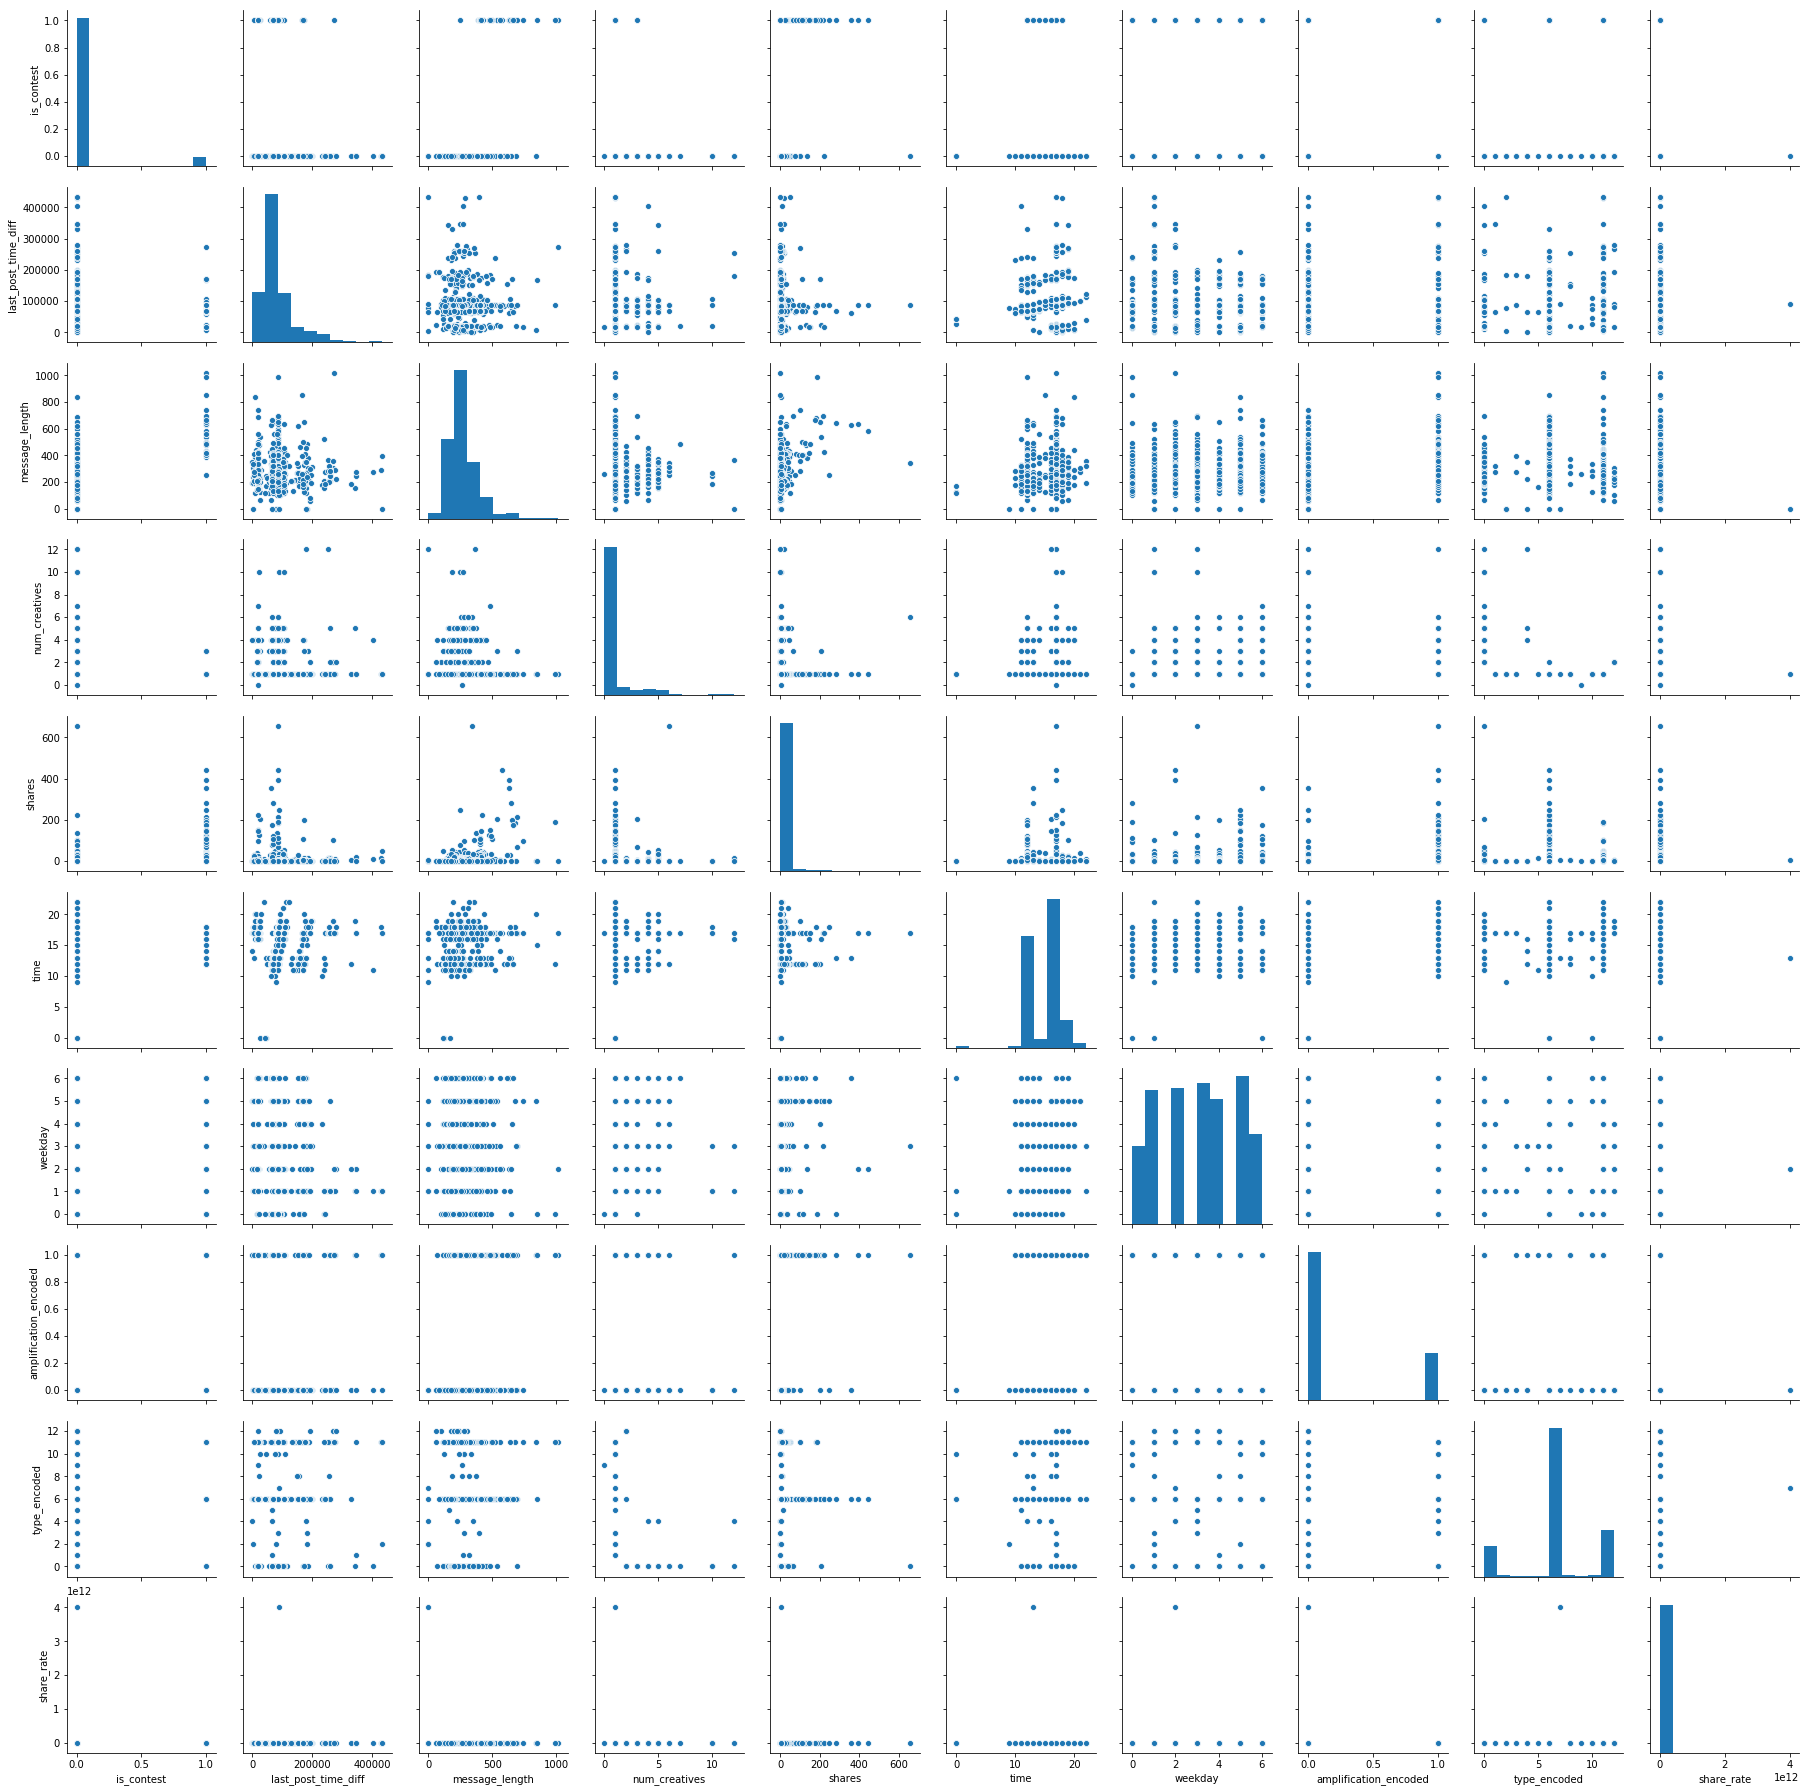

In [1597]:
sns.pairplot(df)

### Outlier is making it difficult to see. Remove the outlier

In [1598]:
df.drop(index=df[df['share_rate'] > 3].index, inplace=True)

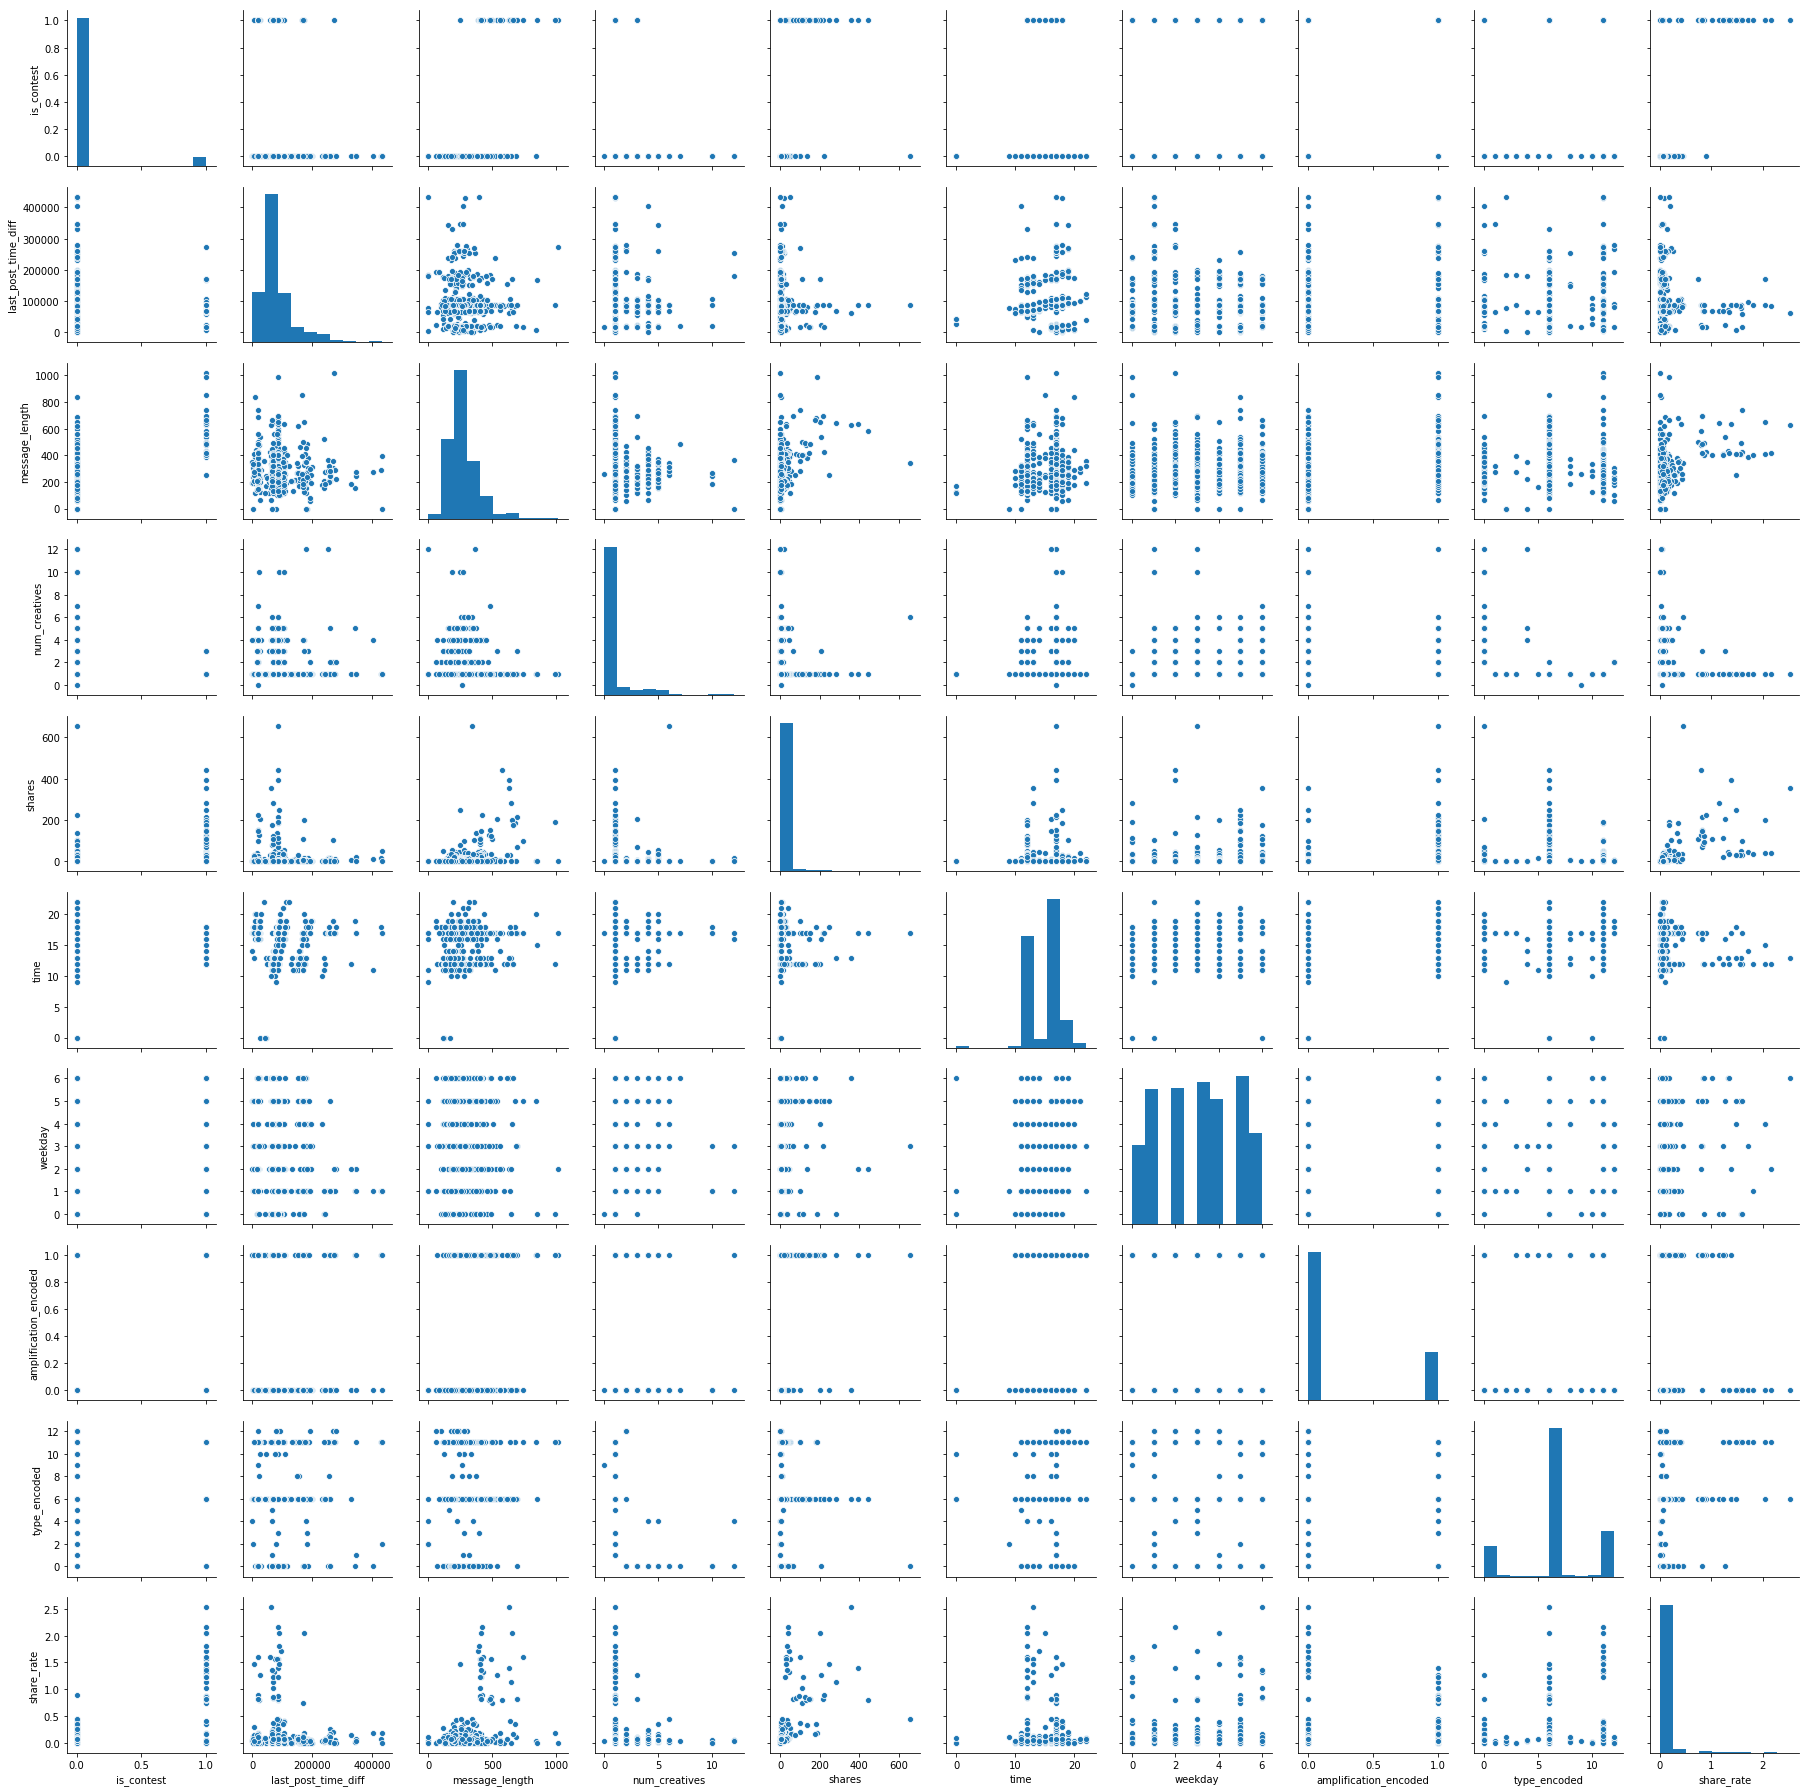

In [1599]:
sns.pairplot(df)

## Correlation

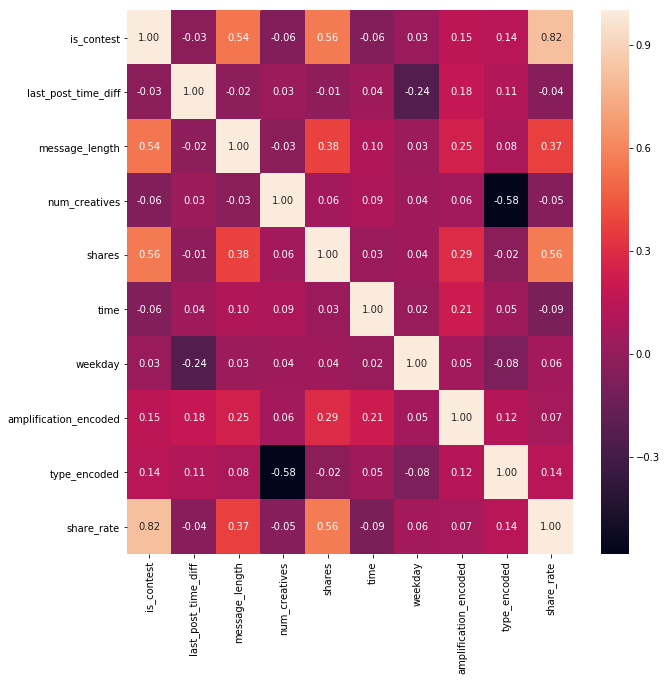

In [1646]:
fig, ax = plt.subplots(figsize=[10, 10])
sns.heatmap(df.corr(), annot=True, fmt='.2f')

## Visualize PCA Plot against target

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


[Text(0, 0.5, 'y'), Text(0.5, 0, 'PCA(x)'), Text(0.5, 1.0, 'PCA(x) vs Y')]

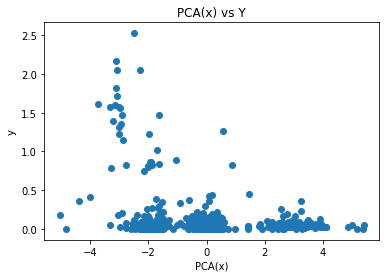

In [1601]:
X = df[features]
y = df[target]

temp_scaler = StandardScaler()
X_scaled_temp = temp_scaler.fit_transform(X)

pca = PCA(n_components=1)
X_pca_temp = pca.fit_transform(X_scaled_temp)


fig, ax = plt.subplots()
ax.scatter(X_pca_temp, y)
ax.set(title="PCA(x) vs Y", xlabel="PCA(x)", ylabel="y")



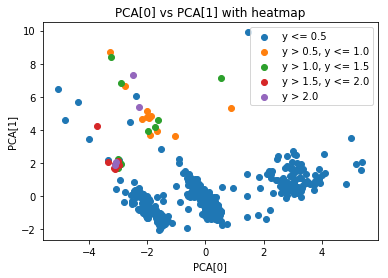

In [1602]:
pca = PCA(n_components=2)
X_pca_temp = pca.fit_transform(X_scaled_temp)

segments = {
    'y <= 0.5' : (y <= 0.5),
    'y > 0.5, y <= 1.0' : (y > 0.5) & (y <= 1.0),
    'y > 1.0, y <= 1.5' : (y > 1.0) & (y <= 1.5),
    'y > 1.5, y <= 2.0' : (y > 1.5) & (y <= 2.0),
    'y > 2.0' : (y > 2.0)
}


fig, ax = plt.subplots()

for segment in segments:    
    mask = segments[segment]
    ax.scatter(X_pca_temp[mask, 0], X_pca_temp[mask, 1], label=segment)
    ax.set(title="PCA[0] vs PCA[1] with heatmap", xlabel="PCA[0]", ylabel="PCA[1]")

ax.legend()


# Train Test Split

In [1603]:

df_train, df_test = train_test_split(
    df, test_size=0.33, random_state=42
)

## See distribution of feature classes, and determine sampling strategy

### amplification

0    359
1    113
Name: amplification_encoded, dtype: int64

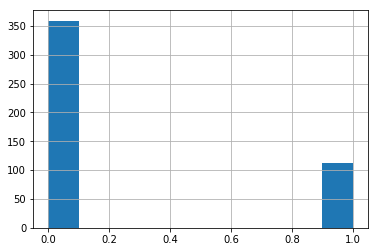

In [1604]:
df_train['amplification_encoded'].hist()
df_train['amplification_encoded'].value_counts()

#### Class 1 is more than 1/5 of class 0. Will not sample

### is_contest

0    447
1     25
Name: is_contest, dtype: int64

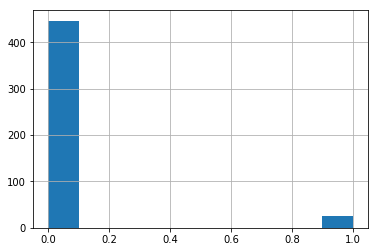

In [1605]:
df_train['is_contest'].hist()
df_train['is_contest'].value_counts()

#### is_contest is an important feature based on pair plot. But it is very imbalanced. Will try to oversample is_contests == 1 by duplicating datapoints to 89 samples (447 / 5)

0    447
1     89
Name: is_contest, dtype: int64

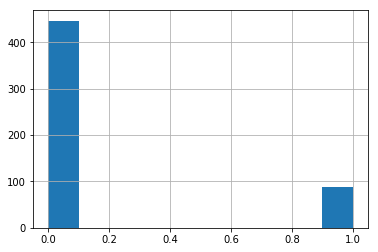

In [1606]:
df_ones = df_train.loc[df['is_contest'] == 1].sample(n=89, replace=True)

df_train = pd.concat([df_ones, df_train[df_train['is_contest'] == 0]])
df_train['is_contest'].hist()
df_train['is_contest'].value_counts()

### type_encoded

6     334
11    117
0      65
12      4
8       4
10      3
4       3
2       2
1       2
9       1
3       1
Name: type_encoded, dtype: int64

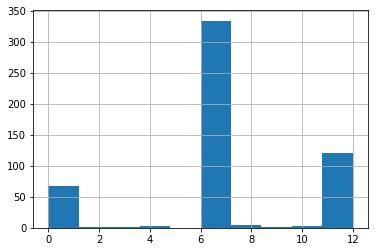

In [1607]:
df_train['type_encoded'].hist()
df_train['type_encoded'].value_counts()

#### classes 1, 2, 3, 4, 5, 8, 9, 10, 12 are very under-represented. Drop these classes

In [1608]:
df_train.drop(
    df_train[
        (df_train['type_encoded'] == 1) 
        | (df_train['type_encoded'] == 2)
        | (df_train['type_encoded'] == 3)
        | (df_train['type_encoded'] == 4)
        | (df_train['type_encoded'] == 5)
        | (df_train['type_encoded'] == 8)
        | (df_train['type_encoded'] == 9)
        | (df_train['type_encoded'] == 10)
        | (df_train['type_encoded'] == 12)
    ].index,
    inplace=True
)

df_train['type_encoded'].value_counts()


6     334
11    117
0      65
Name: type_encoded, dtype: int64

### Weekday

5    98
3    87
2    72
1    72
4    67
0    64
6    56
Name: weekday, dtype: int64

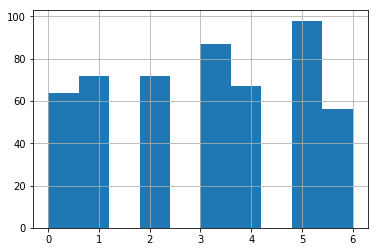

In [1609]:
df_train['weekday'].hist()
df_train['weekday'].value_counts()

#### Weekday is pretty balanced. Will not sample

# Transform features

In [1610]:
X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

print("X_train shape: %s, y_train shape: %s,\n X_test_shape: %s, y_test_shape: %s" % (
    str(X_train.shape), 
    str(y_train.shape), 
    str(X_test.shape), 
    str(y_test.shape)
))

X_train shape: (516, 10), y_train shape: (516,),
 X_test_shape: (233, 10), y_test_shape: (233,)


### Scale

In [1611]:
scaler = StandardScaler()
scaler.fit(X_train)
Z_train = scaler.transform(X_train)
Z_test = scaler.transform(X_test)

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


### PCA (For visualization / debugging only)

In [1647]:
pca = PCA(n_components=1)
pca.fit(Z_train)
Z_train_pca = pca.transform(Z_train)
Z_test_pca = pca.transform(Z_test)

# Model Engineering

### Define Evaluation Function

In [1613]:
def evaluate_model(X_test_pca, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    print("MAE:" + str(mae))
    
    #plot and see differences
    fig, ax = plt.subplots(figsize=[10, 10], nrows=2)
    ax[0].scatter(X_test_pca, y_test, label='truth', marker='o')
    ax[0].scatter(X_test_pca, y_pred, label='predicted', marker='o')
    ax[0].legend()
    ax[0].set(title="PCA(X) vs y", ylabel='y', xlabel="PCA(X)")
    
    ax[1].plot(range(len(y_test)), y_test, label='truth', marker='o')
    ax[1].plot(range(len(y_pred)), y_pred, label='predicted', marker='o')
    ax[1].legend()
    ax[1].set(title="n vs y", ylabel='y', xlabel="n")
    
    return mae
    
    

### Try SGDRegressor
From the PCA plot, there doesn't seem to be a linear relationship between the features and the target. Try to fit a linear model nonetheless


In [1614]:
model_sgd = SGDRegressor()
sgd_param_grid = {
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'l1_ratio': [0.15, 0.2, 0.25, 0.3],
    'max_iter': [10, 20, 30, 40],
    'tol': [1e-3, 1e-4, 1e-2, 1e-1],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}


gs = GridSearchCV(estimator=model_sgd, param_grid=sgd_param_grid, return_train_score=True, cv=3, scoring='neg_mean_absolute_error')
gs.fit(Z_train, y_train)

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.001, 0.01], 'l1_ratio': [0.15, 0.2, 0.25, 0.3], 'max_iter': [10, 20, 30, 40], 'tol': [0.001, 0.0001, 0.01, 0.1], 'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [1615]:
model_sgd = gs.best_estimator_

MAE:0.12883799459182685


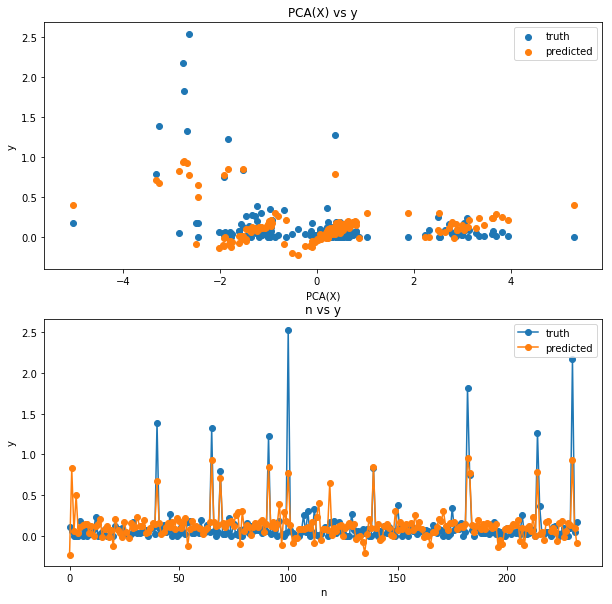

In [1616]:
y_pred_sgd = model_sgd.predict(Z_test)
mae_sgd = evaluate_model(Z_test_pca, y_test, y_pred_sgd)

### Try SGDRegressor with a polynomial transform
From the PCA plot, there doesn't seem to be a linear relationship between the features and the target. Try to fit a linear model with polynomial transformation nonetheless


In [1650]:
polynomial_transformer = PolynomialFeatures(degree=3)
polynomial_transformer.fit(Z_train)
Z_train_poly = polynomial_transformer.transform(Z_train)
Z_test_poly = polynomial_transformer.transform(Z_test)

In [1670]:
model_sgd_poly = SGDRegressor()
sgd_param_grid_poly = {
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'l1_ratio': [0.15, 0.2, 0.25, 0.3],
    'max_iter': [10, 20, 30, 40],
    'tol': [1e-3, 1e-4, 1e-2, 1e-1],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}


gs_poly = GridSearchCV(estimator=model_sgd_poly, param_grid=sgd_param_grid_poly, return_train_score=True, cv=3, scoring='neg_mean_absolute_error')
gs_poly.fit(Z_train_poly, y_train)

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Francis\Anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Converge

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.001, 0.01], 'l1_ratio': [0.15, 0.2, 0.25, 0.3], 'max_iter': [10, 20, 30, 40], 'tol': [0.001, 0.0001, 0.01, 0.1], 'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [1671]:
model_sgd_poly = gs_poly.best_estimator_

MAE:0.09304493569953005


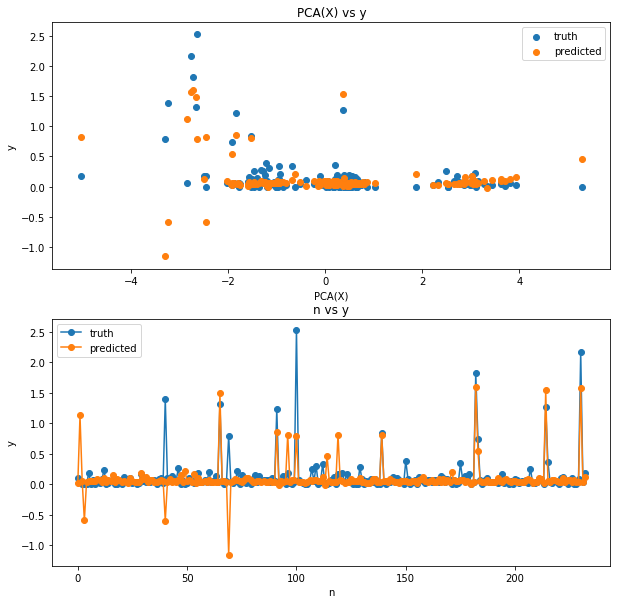

In [1672]:
y_pred_sgd_poly = model_sgd_poly.predict(Z_test_poly)
mae_sgd_poly = evaluate_model(Z_test_pca, y_test, y_pred_sgd_poly)

## Try Neural Network (MLP)

In [1676]:
model_mlp = Sequential()
model_mlp.add(Dense(2, input_shape=(Z_train.shape[1],)))
model_mlp.add(Dense(2))
model_mlp.add(Dense(1))
model_mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_159 (Dense)            (None, 2)                 22        
_________________________________________________________________
dense_160 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_161 (Dense)            (None, 1)                 3         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [1677]:
plot_model(model_mlp, to_file='fb_model_mlp.png')

<img src="fb_model_mlp.png" />

In [1678]:
early_stop_mlp = EarlyStopping(patience=10)
mlp_checkpoint = ModelCheckpoint('mlp.{epoch:02d}.hdf5')

# optimizer_mlp = Adam(lr=1e-3)
optimizer_mlp = SGD(lr=1e-3)
batch_size_mlp = 128
model_mlp.compile(loss='mae',
              optimizer=optimizer_mlp,
              metrics=['mae'])

In [1679]:
epochs_mlp = 1000

history_mlp = model_mlp.fit(Z_train, y_train,
                    batch_size=batch_size_mlp,
                    epochs=epochs_mlp,
                    verbose=1,
                    callbacks=[mlp_checkpoint, early_stop_mlp],
                    validation_data=(X_test, y_test))

Train on 516 samples, validate on 233 samples
Epoch 1/1000
516/516 [==============================] - 1s 3ms/step - loss: 0.6890 - mean_absolute_error: 0.6890 - val_loss: 6713.1299 - val_mean_absolute_error: 6713.1299
Epoch 2/1000
516/516 [==============================] - 0s 94us/step - loss: 0.6806 - mean_absolute_error: 0.6806 - val_loss: 6673.1444 - val_mean_absolute_error: 6673.1444
Epoch 3/1000
516/516 [==============================] - 0s 79us/step - loss: 0.6718 - mean_absolute_error: 0.6718 - val_loss: 6647.8664 - val_mean_absolute_error: 6647.8664
Epoch 4/1000
516/516 [==============================] - 0s 81us/step - loss: 0.6625 - mean_absolute_error: 0.6625 - val_loss: 6616.6652 - val_mean_absolute_error: 6616.6652
Epoch 5/1000
516/516 [==============================] - 0s 77us/step - loss: 0.6539 - mean_absolute_error: 0.6539 - val_loss: 6574.1499 - val_mean_absolute_error: 6574.1499
Epoch 6/1000
516/516 [==============================] - 0s 70us/step - loss: 0.6447 - mean

Epoch 48/1000
516/516 [==============================] - 0s 77us/step - loss: 0.3999 - mean_absolute_error: 0.3999 - val_loss: 5774.4275 - val_mean_absolute_error: 5774.4275
Epoch 49/1000
516/516 [==============================] - 0s 97us/step - loss: 0.3967 - mean_absolute_error: 0.3967 - val_loss: 5752.4031 - val_mean_absolute_error: 5752.4031
Epoch 50/1000
516/516 [==============================] - 0s 72us/step - loss: 0.3928 - mean_absolute_error: 0.3928 - val_loss: 5712.7205 - val_mean_absolute_error: 5712.7205
Epoch 51/1000
516/516 [==============================] - 0s 79us/step - loss: 0.3881 - mean_absolute_error: 0.3881 - val_loss: 5680.8138 - val_mean_absolute_error: 5680.8138
Epoch 52/1000
516/516 [==============================] - 0s 72us/step - loss: 0.3845 - mean_absolute_error: 0.3845 - val_loss: 5626.2317 - val_mean_absolute_error: 5626.2317
Epoch 53/1000
516/516 [==============================] - 0s 81us/step - loss: 0.3818 - mean_absolute_error: 0.3818 - val_loss: 561

Epoch 95/1000
516/516 [==============================] - 0s 72us/step - loss: 0.2957 - mean_absolute_error: 0.2957 - val_loss: 4460.0532 - val_mean_absolute_error: 4460.0532
Epoch 96/1000
516/516 [==============================] - 0s 79us/step - loss: 0.2942 - mean_absolute_error: 0.2942 - val_loss: 4435.2899 - val_mean_absolute_error: 4435.2899
Epoch 97/1000
516/516 [==============================] - 0s 85us/step - loss: 0.2927 - mean_absolute_error: 0.2927 - val_loss: 4415.6086 - val_mean_absolute_error: 4415.6086
Epoch 98/1000
516/516 [==============================] - 0s 77us/step - loss: 0.2916 - mean_absolute_error: 0.2916 - val_loss: 4386.3731 - val_mean_absolute_error: 4386.3731
Epoch 99/1000
516/516 [==============================] - 0s 81us/step - loss: 0.2908 - mean_absolute_error: 0.2908 - val_loss: 4322.2366 - val_mean_absolute_error: 4322.2366
Epoch 100/1000
516/516 [==============================] - 0s 79us/step - loss: 0.2895 - mean_absolute_error: 0.2895 - val_loss: 43

Epoch 142/1000
516/516 [==============================] - 0s 79us/step - loss: 0.2590 - mean_absolute_error: 0.2590 - val_loss: 3084.7146 - val_mean_absolute_error: 3084.7146
Epoch 143/1000
516/516 [==============================] - 0s 75us/step - loss: 0.2585 - mean_absolute_error: 0.2585 - val_loss: 3056.8868 - val_mean_absolute_error: 3056.8868
Epoch 144/1000
516/516 [==============================] - 0s 75us/step - loss: 0.2579 - mean_absolute_error: 0.2579 - val_loss: 3027.0178 - val_mean_absolute_error: 3027.0178
Epoch 145/1000
516/516 [==============================] - 0s 81us/step - loss: 0.2575 - mean_absolute_error: 0.2575 - val_loss: 3008.4948 - val_mean_absolute_error: 3008.4948
Epoch 146/1000
516/516 [==============================] - 0s 79us/step - loss: 0.2571 - mean_absolute_error: 0.2571 - val_loss: 2980.2790 - val_mean_absolute_error: 2980.2790
Epoch 147/1000
516/516 [==============================] - 0s 75us/step - loss: 0.2567 - mean_absolute_error: 0.2567 - val_los

516/516 [==============================] - 0s 75us/step - loss: 0.2395 - mean_absolute_error: 0.2395 - val_loss: 2163.4329 - val_mean_absolute_error: 2163.4329
Epoch 189/1000
516/516 [==============================] - 0s 66us/step - loss: 0.2392 - mean_absolute_error: 0.2392 - val_loss: 2158.0587 - val_mean_absolute_error: 2158.0587
Epoch 190/1000
516/516 [==============================] - 0s 73us/step - loss: 0.2389 - mean_absolute_error: 0.2389 - val_loss: 2126.7394 - val_mean_absolute_error: 2126.7394
Epoch 191/1000
516/516 [==============================] - 0s 75us/step - loss: 0.2385 - mean_absolute_error: 0.2385 - val_loss: 2111.8442 - val_mean_absolute_error: 2111.8442
Epoch 192/1000
516/516 [==============================] - 0s 73us/step - loss: 0.2382 - mean_absolute_error: 0.2382 - val_loss: 2088.0729 - val_mean_absolute_error: 2088.0729
Epoch 193/1000
516/516 [==============================] - 0s 77us/step - loss: 0.2380 - mean_absolute_error: 0.2380 - val_loss: 2063.2330 - 

Epoch 235/1000
516/516 [==============================] - 0s 77us/step - loss: 0.2269 - mean_absolute_error: 0.2269 - val_loss: 1430.7888 - val_mean_absolute_error: 1430.7888
Epoch 236/1000
516/516 [==============================] - 0s 85us/step - loss: 0.2267 - mean_absolute_error: 0.2267 - val_loss: 1398.6888 - val_mean_absolute_error: 1398.6888
Epoch 237/1000
516/516 [==============================] - 0s 85us/step - loss: 0.2265 - mean_absolute_error: 0.2265 - val_loss: 1386.4023 - val_mean_absolute_error: 1386.4023
Epoch 238/1000
516/516 [==============================] - 0s 157us/step - loss: 0.2263 - mean_absolute_error: 0.2263 - val_loss: 1367.6188 - val_mean_absolute_error: 1367.6188
Epoch 239/1000
516/516 [==============================] - 0s 103us/step - loss: 0.2261 - mean_absolute_error: 0.2261 - val_loss: 1366.8445 - val_mean_absolute_error: 1366.8445
Epoch 240/1000
516/516 [==============================] - 0s 120us/step - loss: 0.2258 - mean_absolute_error: 0.2258 - val_

Epoch 282/1000
516/516 [==============================] - 0s 83us/step - loss: 0.2183 - mean_absolute_error: 0.2183 - val_loss: 845.6433 - val_mean_absolute_error: 845.6433
Epoch 283/1000
516/516 [==============================] - 0s 106us/step - loss: 0.2181 - mean_absolute_error: 0.2181 - val_loss: 828.9424 - val_mean_absolute_error: 828.9424
Epoch 284/1000
516/516 [==============================] - 0s 162us/step - loss: 0.2179 - mean_absolute_error: 0.2179 - val_loss: 843.7482 - val_mean_absolute_error: 843.7482
Epoch 285/1000
516/516 [==============================] - 0s 101us/step - loss: 0.2178 - mean_absolute_error: 0.2178 - val_loss: 835.2865 - val_mean_absolute_error: 835.2865
Epoch 286/1000
516/516 [==============================] - 0s 101us/step - loss: 0.2176 - mean_absolute_error: 0.2176 - val_loss: 827.6862 - val_mean_absolute_error: 827.6862
Epoch 287/1000
516/516 [==============================] - 0s 95us/step - loss: 0.2175 - mean_absolute_error: 0.2175 - val_loss: 810

516/516 [==============================] - 0s 114us/step - loss: 0.2131 - mean_absolute_error: 0.2131 - val_loss: 526.8730 - val_mean_absolute_error: 526.8730
Epoch 330/1000
516/516 [==============================] - 0s 108us/step - loss: 0.2131 - mean_absolute_error: 0.2131 - val_loss: 525.6486 - val_mean_absolute_error: 525.6486
Epoch 331/1000
516/516 [==============================] - 0s 81us/step - loss: 0.2130 - mean_absolute_error: 0.2130 - val_loss: 511.1373 - val_mean_absolute_error: 511.1373
Epoch 332/1000
516/516 [==============================] - 0s 81us/step - loss: 0.2129 - mean_absolute_error: 0.2129 - val_loss: 501.7484 - val_mean_absolute_error: 501.7484
Epoch 333/1000
516/516 [==============================] - 0s 73us/step - loss: 0.2128 - mean_absolute_error: 0.2128 - val_loss: 498.7614 - val_mean_absolute_error: 498.7614
Epoch 334/1000
516/516 [==============================] - 0s 120us/step - loss: 0.2127 - mean_absolute_error: 0.2127 - val_loss: 486.5317 - val_mean

516/516 [==============================] - 0s 73us/step - loss: 0.2099 - mean_absolute_error: 0.2099 - val_loss: 280.9755 - val_mean_absolute_error: 280.9755
Epoch 377/1000
516/516 [==============================] - 0s 72us/step - loss: 0.2098 - mean_absolute_error: 0.2098 - val_loss: 280.3991 - val_mean_absolute_error: 280.3991
Epoch 378/1000
516/516 [==============================] - 0s 91us/step - loss: 0.2098 - mean_absolute_error: 0.2098 - val_loss: 274.7962 - val_mean_absolute_error: 274.7962


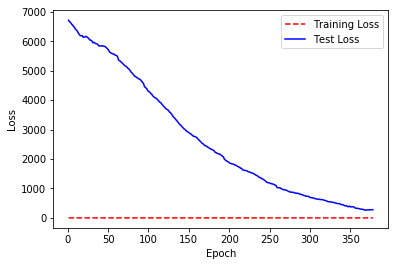

In [1680]:
# Get training and test loss histories
training_loss = history_mlp.history['loss']
test_loss = history_mlp.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [1681]:
best_model_epoch = np.argmin(test_loss)
#load model
model_filename = "mlp.%s.hdf5" % best_model_epoch
model_mlp.load_weights(model_filename)

MAE:0.14046346849183472


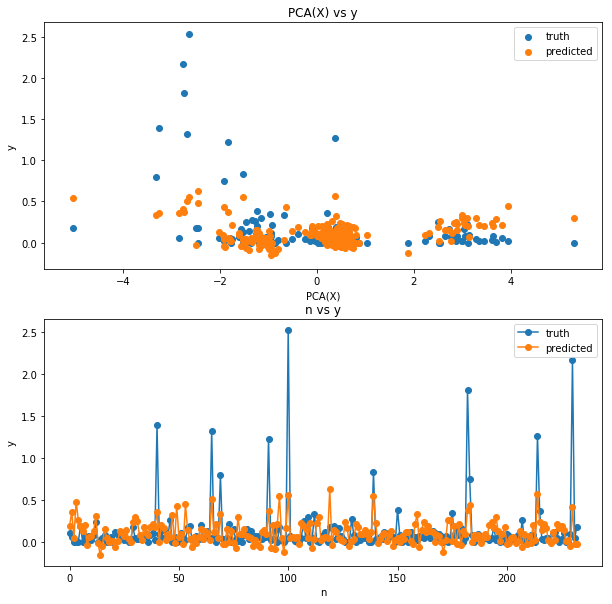

In [1682]:
y_pred_mlp = model_mlp.predict(Z_test)
mae_mlp = evaluate_model(Z_test_pca, y_test, y_pred_mlp)

## Try Neural Network (Word Embeddings with MLP)

In [1628]:
df_messages_train = df.loc[X_train.index]['message']
df_messages_test = df.loc[X_test.index]['message']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_messages_train)

max_length = 4
vocab_size = len(tokenizer.word_index)

encoded_docs_train = [one_hot(d, vocab_size) for d in df_messages_train]
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')

encoded_docs_test = [one_hot(d, vocab_size) for d in df_messages_test]
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')


In [1629]:

first_input = Input(shape=(max_length, ))
first_dense = Embedding(vocab_size, 8)(first_input)
first_flattened = Flatten()(first_dense)

second_input = Input(shape=(Z_train.shape[1], ))
second_dense = Dense(5)(second_input)

merge_one = concatenate([first_flattened, second_dense])
third_dense = Dense(17)(merge_one)
fourth_dense = Dense(5)(third_dense)

output = Dense(1)(fourth_dense)

model_embeddings_mlp = Model(inputs=[first_input, second_input], outputs=output)
optimizer_embeddings_mlp = Adam(lr=1e-3)
model_embeddings_mlp.compile(optimizer=optimizer_embeddings_mlp, loss='mae', metrics=['mae'])
model_embeddings_mlp.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 4, 8)         23224       input_20[0][0]                   
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 32)           0           embedding_11[0][0]               
__________________________________________________________________________________________________
dense_155 

In [1675]:
plot_model(model_embeddings_mlp, to_file='fb_model.png')


<img src="fb_model.png" />

In [1631]:
embeddings_mlp_checkpoint = ModelCheckpoint('embeddings_mlp.{epoch:02d}.hdf5')
early_stop_embeddings_mlp = EarlyStopping(patience=10)
batch_size_embeddings_mlp = 100
epochs_embeddings_mlp = 1000
history_embeddings_mlp = model_embeddings_mlp.fit(
    [padded_docs_train, Z_train], 
    y_train, 
    epochs=epochs_embeddings_mlp, 
    validation_data=([padded_docs_test,Z_test],y_test), 
    batch_size=batch_size_embeddings_mlp, 
    verbose=1,
    callbacks=[embeddings_mlp_checkpoint, early_stop_embeddings_mlp]
)

Train on 516 samples, validate on 233 samples
Epoch 1/1000
516/516 [==============================] - 2s 3ms/step - loss: 0.5117 - mean_absolute_error: 0.5117 - val_loss: 0.4358 - val_mean_absolute_error: 0.4358
Epoch 2/1000
516/516 [==============================] - 0s 124us/step - loss: 0.3806 - mean_absolute_error: 0.3806 - val_loss: 0.3092 - val_mean_absolute_error: 0.3092
Epoch 3/1000
516/516 [==============================] - 0s 114us/step - loss: 0.2955 - mean_absolute_error: 0.2955 - val_loss: 0.2390 - val_mean_absolute_error: 0.2390
Epoch 4/1000
516/516 [==============================] - 0s 108us/step - loss: 0.2553 - mean_absolute_error: 0.2553 - val_loss: 0.1951 - val_mean_absolute_error: 0.1951
Epoch 5/1000
516/516 [==============================] - 0s 110us/step - loss: 0.2106 - mean_absolute_error: 0.2106 - val_loss: 0.1671 - val_mean_absolute_error: 0.1671
Epoch 6/1000
516/516 [==============================] - 0s 112us/step - loss: 0.1813 - mean_absolute_error: 0.1813 -

516/516 [==============================] - 0s 137us/step - loss: 0.0411 - mean_absolute_error: 0.0411 - val_loss: 0.1080 - val_mean_absolute_error: 0.1080
Epoch 50/1000
516/516 [==============================] - 0s 211us/step - loss: 0.0411 - mean_absolute_error: 0.0411 - val_loss: 0.1075 - val_mean_absolute_error: 0.1075
Epoch 51/1000
516/516 [==============================] - 0s 170us/step - loss: 0.0420 - mean_absolute_error: 0.0420 - val_loss: 0.1075 - val_mean_absolute_error: 0.1075
Epoch 52/1000
516/516 [==============================] - 0s 137us/step - loss: 0.0420 - mean_absolute_error: 0.0420 - val_loss: 0.1093 - val_mean_absolute_error: 0.1093
Epoch 53/1000
516/516 [==============================] - 0s 162us/step - loss: 0.0430 - mean_absolute_error: 0.0430 - val_loss: 0.1061 - val_mean_absolute_error: 0.1061
Epoch 54/1000
516/516 [==============================] - 0s 174us/step - loss: 0.0409 - mean_absolute_error: 0.0409 - val_loss: 0.1077 - val_mean_absolute_error: 0.1077


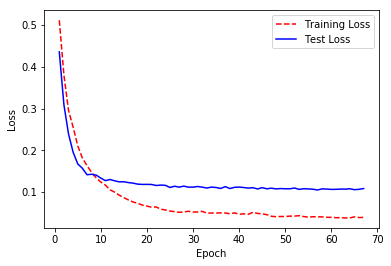

In [1632]:
# Get training and test loss histories
training_loss = history_embeddings_mlp.history['loss']
test_loss = history_embeddings_mlp.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [1633]:
best_model_epoch = np.argmin(test_loss)
#load model
model_filename = "embeddings_mlp.%s.hdf5" % best_model_epoch
model_embeddings_mlp.load_weights(model_filename)

MAE:0.10648250725404775


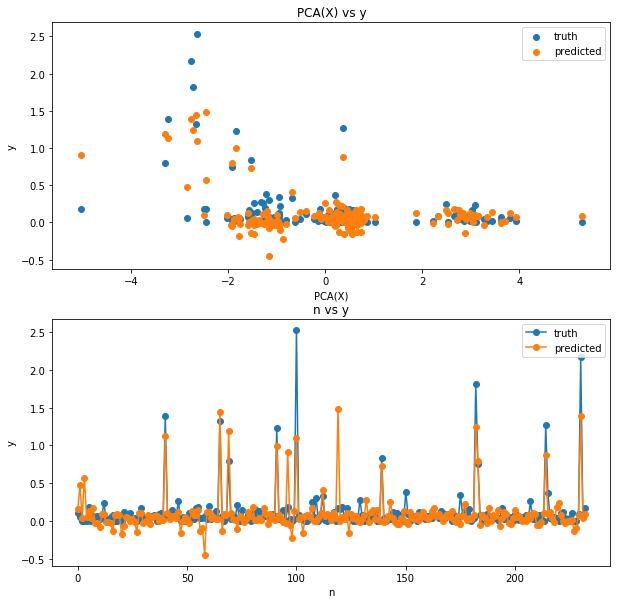

In [1634]:
y_pred_embeddings_mlp = model_embeddings_mlp.predict([padded_docs_test, Z_test])
mae_embeddings_mlp = evaluate_model(Z_test_pca, y_test, y_pred_embeddings_mlp)

# Best Scoring Model

In [1683]:
model_names = pd.DataFrame(['SGD', 'SGD with Polynomial Transformation', 'MLP', 'MLP With Embeddings'], columns=['Model type'])
model_scores = pd.DataFrame([mae_sgd, mae_sgd_poly, mae_mlp, mae_embeddings_mlp], columns=['MAE'])
df_model_scores = pd.concat([model_names, model_scores], axis=1)
df_model_scores

Model type       MAE
0                                 SGD  0.128838
1  SGD with Polynomial Transformation  0.093045
2                                 MLP  0.140463
3                 MLP With Embeddings  0.106483

- The best model for keeps changing with every run; everytime you re-run the training, you get different results. The best solution always seem to hover around 0.08 to 0.09 though

# Try gathering more insights

## See distribution of y

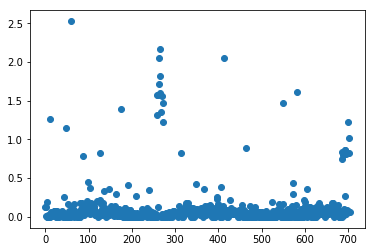

In [1636]:
plt.scatter(range(len(df)), df['share_rate'])

### Seems most fall within the 0 - 0.3 range. Try and see what kind of posts are above 0.3

In [1637]:
df_outliers = df[df['share_rate'] > 0.3]
df_outliers

is_contest  last_post_time_diff  \
11            1                24445   
48            1                68401   
60            1                62699   
86            1                86401   
99            0                86401   
102           0                82800   
126           1                86400   
136           0                82314   
147           1                84300   
164           0                79200   
174           1                86401   
191           1               105253   
239           0                81445   
258           1                86414   
259           1                72937   
261           1                77213   
262           1                88431   
263           1                96374   
264           1                84408   
265           1                87714   
266           1                59844   
268           1                66668   
270           1                82846   
271           1                 6426   
273           1                67787   
313           1                86210   
350           0                87569   
369           0                68813   
407           0               104400   
416           1               171885   
466           0                18358   
551           1                87629   
574           0                 6682   
575           0                81708   
583           1                17746   
608           0               102431   
689           1                68400   
690           1               169893   
691           1                22168   
696           1                86400   
697           1                68400   
698           1                17645   
704           1                86403   
705           1                68485   
706           1                18110   

                                               message  message_length  \
11   [CONTEST] Tis' the season of gifting and weâ€™...             539   
48   [CONTEST] What's the latest anti-aging care fr...             645   
60   [CONTEST] Our brand new THEFACESHOP-Nature Col...             629   
86   [CONTEST] Spot & Win #THEFACESHOPSGxKAKAOFrien...             581   
99   Freshly launched! Your favourite #THEFACESHOPS...             345   
102  Sweet dreams are made of these. Get first dibs...             279   
126  [CONTEST] Pause and Refresh with #THEFACESHOPS...             698   
136  3 MORE DAYS. Weâ€™re counting down to sweeter ...             377   
147  [CONTEST] Packed with a punch of powerful bene...             681   
164  This is the moment youâ€™ve been waiting for! ...             253   
174  [CONTEST] I spy with my little eyes. Ginseng, ...             633   
191  [WIN] Ward off skin woes with #DrBelmeurToTheR...             636   
239  Flat Velvet & Glossy Lipsticks â€“ Express sof...             193   
258  ðŸŽ�THEFACESHOP CHRISTMAS GIVEAWAY CONTEST - D...             494   
259  ðŸŽ�THEFACESHOP CHRISTMAS GIVEAWAY CONTEST - D...             430   
261  ðŸŽ�THEFACESHOP CHRISTMAS GIVEAWAY CONTEST - D...             406   
262  ðŸŽ�THEFACESHOP CHRISTMAS GIVEAWAY CONTEST - D...             409   
263  ðŸŽ�THEFACESHOP CHRISTMAS GIVEAWAY CONTEST - D...             386   
264  ðŸŽ�THEFACESHOP CHRISTMAS GIVEAWAY CONTEST - D...             420   
265  ðŸŽ�THEFACESHOP CHRISTMAS GIVEAWAY CONTEST - D...             399   
266  ðŸŽ�THEFACESHOP CHRISTMAS GIVEAWAY CONTEST - D...             425   
268  ðŸŽ�THEFACESHOP CHRISTMAS GIVEAWAY CONTEST - D...             415   
270  ðŸŽ�THEFACESHOP CHRISTMAS GIVEAWAY CONTEST - D...             411   
271  ðŸŽ�THEFACESHOP CHRISTMAS GIVEAWAY CONTEST - D...             406   
273  ðŸŽ�THEFACESHOP CHRISTMAS GIVEAWAY CONTEST - D...             411   
313  [Contest Closed!]\n\nWe had a great time watch...             697   
350  To kick start the month of October, here's som...             219   
369  [Flash & Redeem]\nHere's a special treat for a...             357   
407  Besides being

In [1638]:
# store plotting logic as a helper function
def plot_x_vs_y(df, xcol, ycols, xclasses=False):
    
    for ycol in ycols:
    
        fig, ax = plt.subplots(nrows=3, figsize=[20, 20])

        #Scatter plot
        ax[0].scatter(df[xcol], df[ycol])
        ax[0].set(title="%s vs %s" % (xcol, ycol), xlabel=xcol, ylabel=ycol)

        #median
        df_median = []
        df_mean = []
        x_sorted = np.sort(df[xcol].unique())
        labels = []

        for i in x_sorted:
            df_median.append(df[df[xcol] == i][ycol].median())
            df_mean.append(df[df[xcol] == i][ycol].mean())
            if type(xclasses) == bool and xclasses == False:
                labels.append(i)
            else:
                labels.append(xclasses[i])

        ax[1].plot(labels, df_mean, marker='o', label='mean', alpha=0.5)
        ax[1].plot(labels, df_median, marker='o', label='median', alpha=0.5)
        ax[1].set(title="%s vs %s (Average)" % (xcol, ycol), xlabel=xcol, ylabel=ycol)
        ax[1].legend()
        for tick in ax[1].get_xticklabels():
            tick.set_rotation(45)

        #histogram
    #     print(df[xcol].value_counts())

        df_count = np.zeros(len(df[xcol].unique()))

        # Cannot use histogram cos it won't have labels
        for i in range(len(x_sorted)):
            df_count[i] = (df[xcol] == x_sorted[i]).sum()

        ax[2].bar(labels, df_count)
        for tick in ax[2].get_xticklabels():
            tick.set_rotation(45)


        ax[2].set(title="%s Histogram" % (xcol), xlabel=xcol, ylabel='Count')
    

### Seems like most high performing posts are contests. Plot and explore

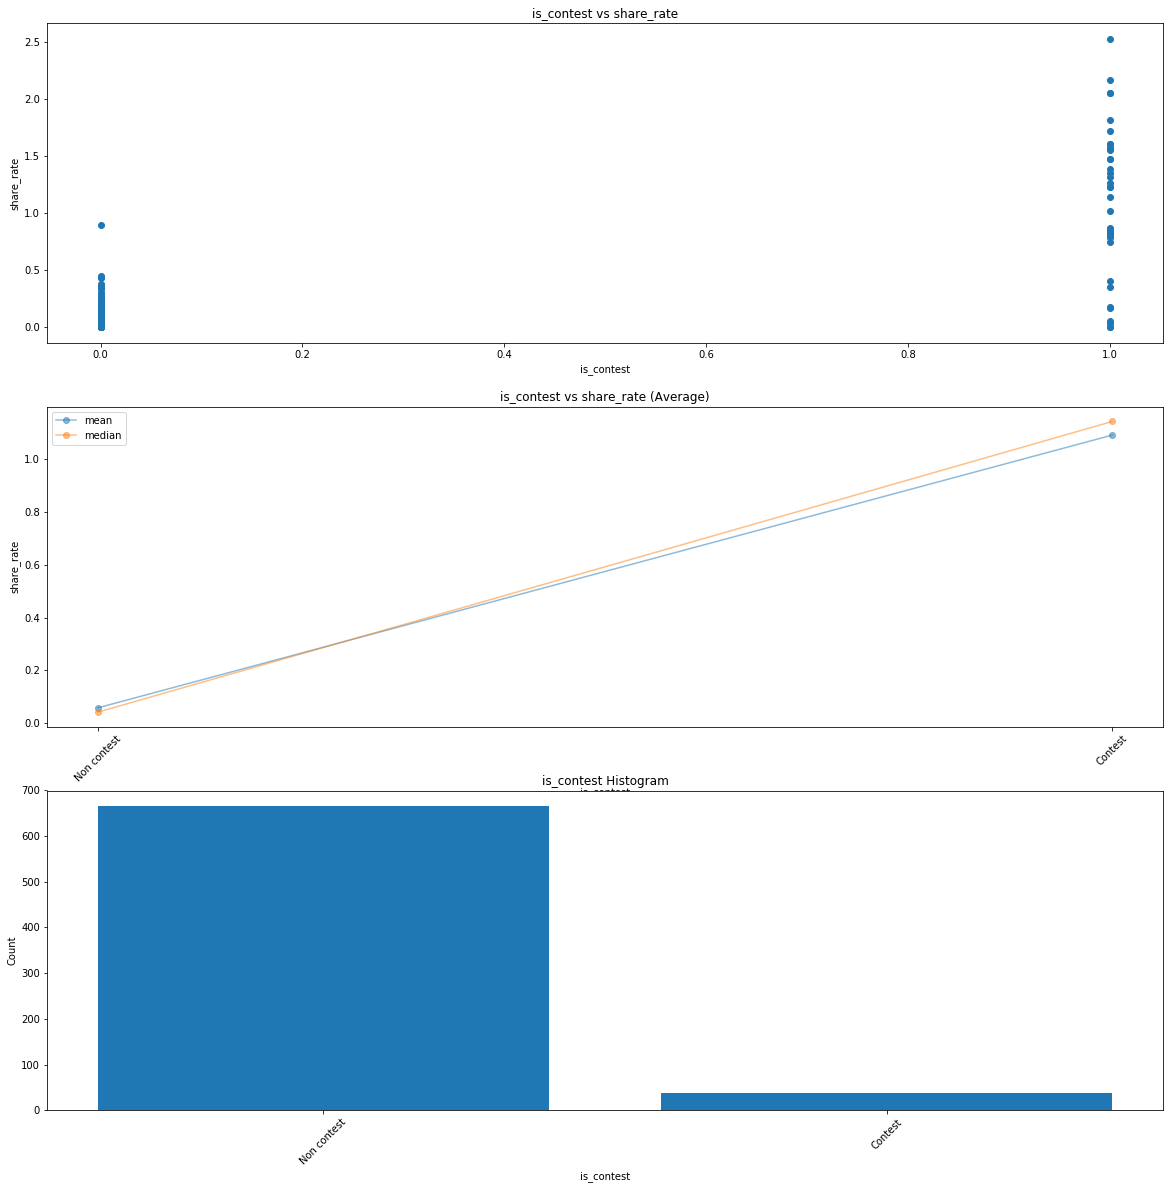

In [1639]:
plot_x_vs_y(df=df, xcol='is_contest', ycols=['share_rate'], xclasses=['Non contest', 'Contest'])

#### Seems like is_contest contributes a lot to share rate

### Amplification

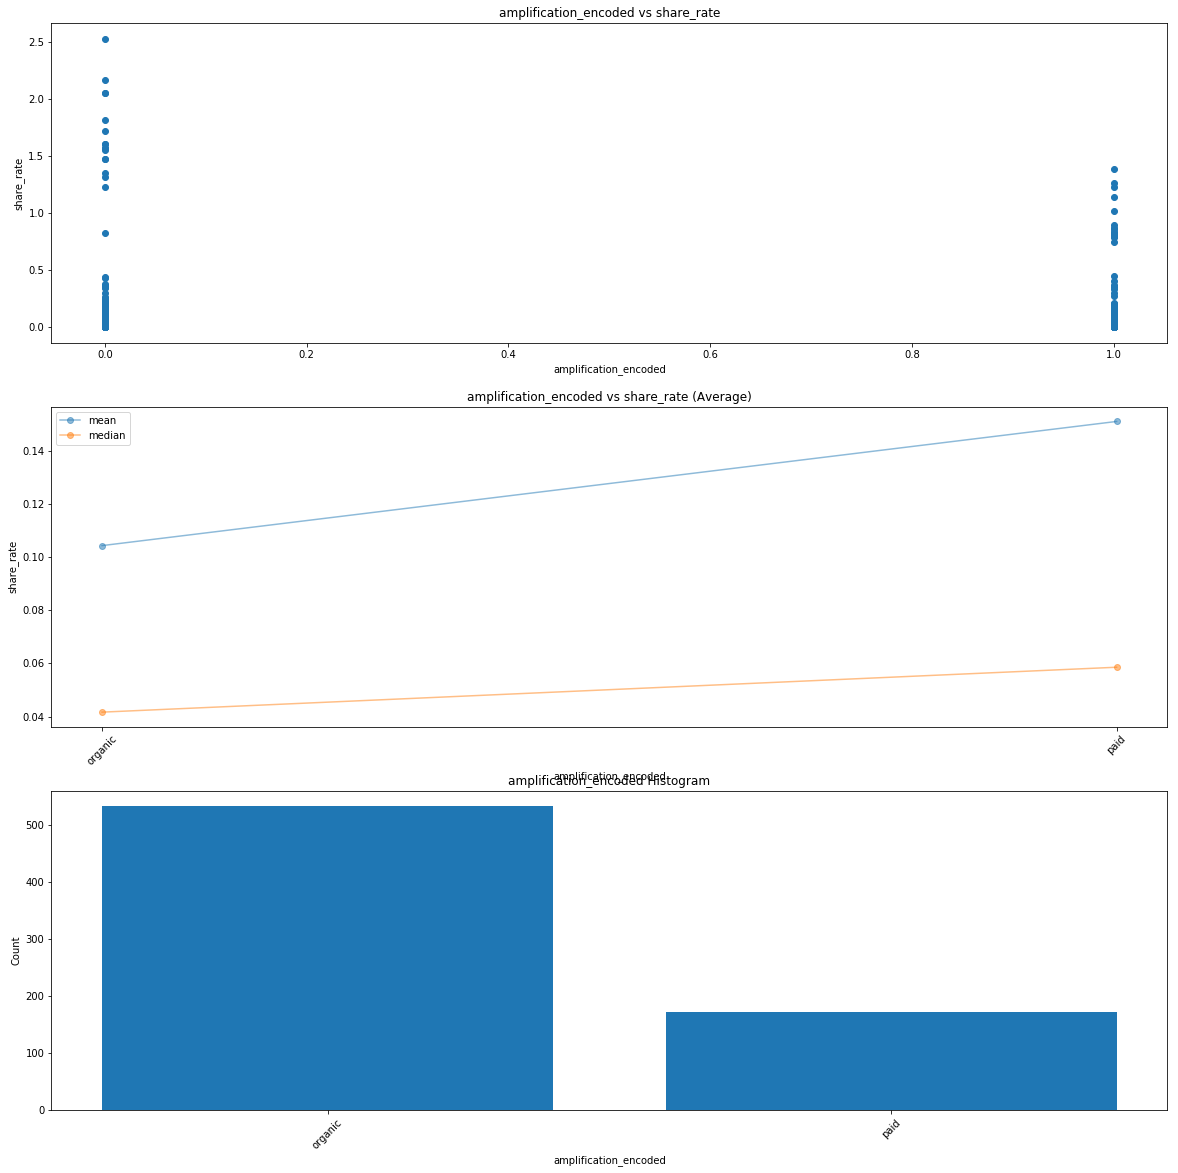

In [1640]:
plot_x_vs_y(df=df, xcol='amplification_encoded', ycols=['share_rate'], xclasses=encoders['amplification'].classes_)

#### There isn't a big difference in median share_rate between paid and organic posts (Around 0.01%)

### Content Type

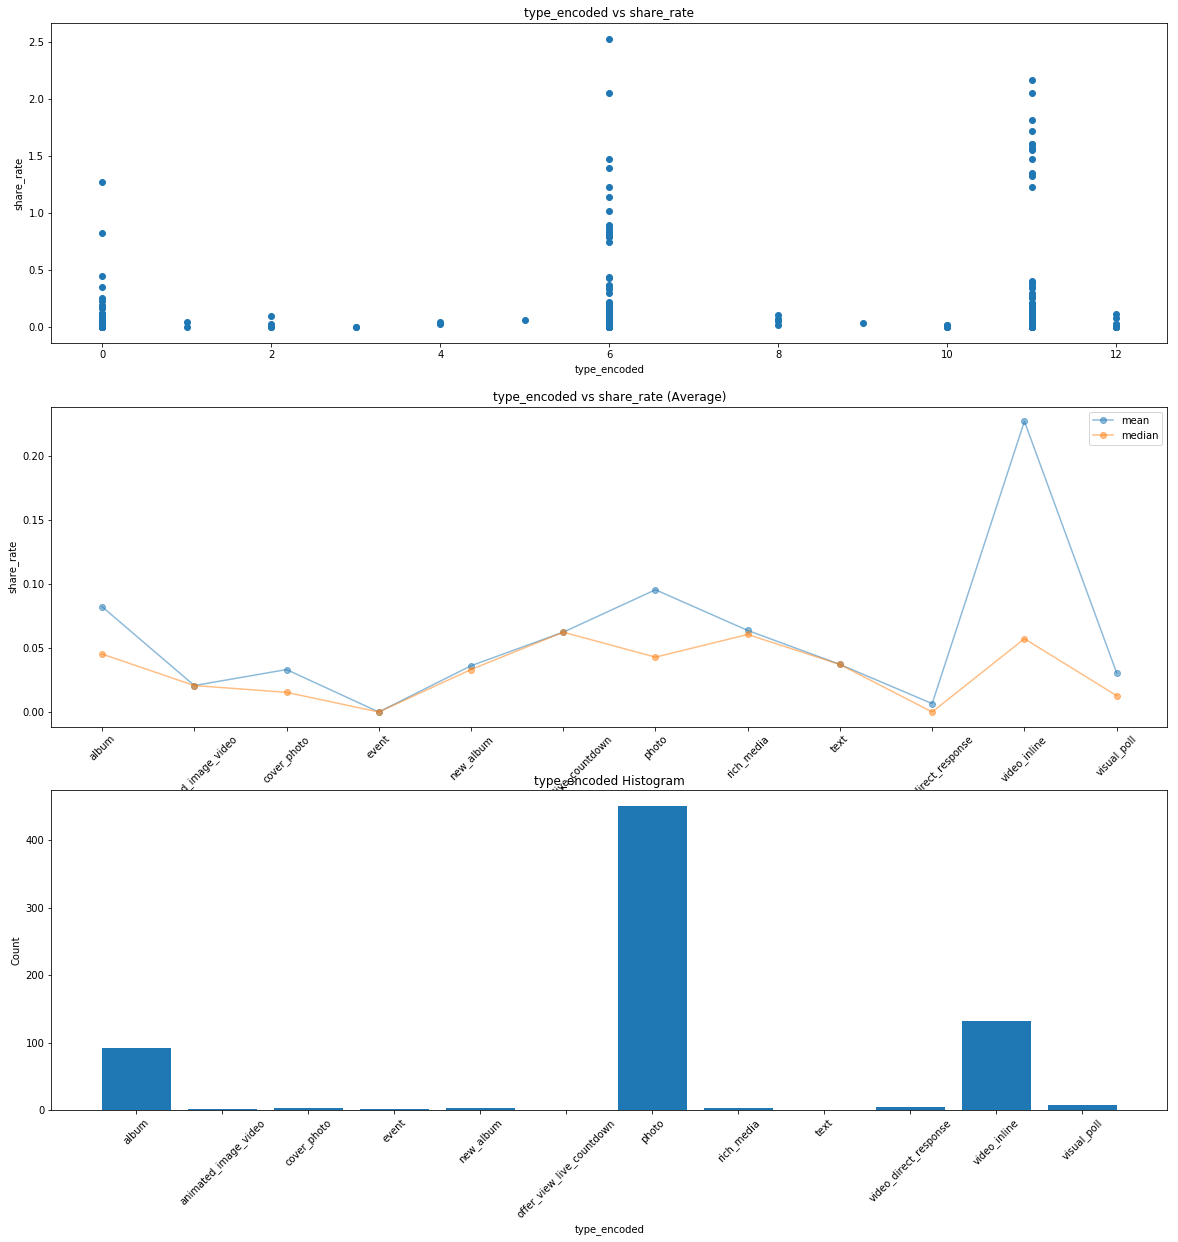

In [1641]:
plot_x_vs_y(df=df, xcol='type_encoded', ycols=['share_rate'], xclasses=encoders['type'].classes_)

#### Due to the low occurance of certain classes, it is difficult to draw a conclusion. However within the majority classes, video_inline seems to perform better

### Weekday

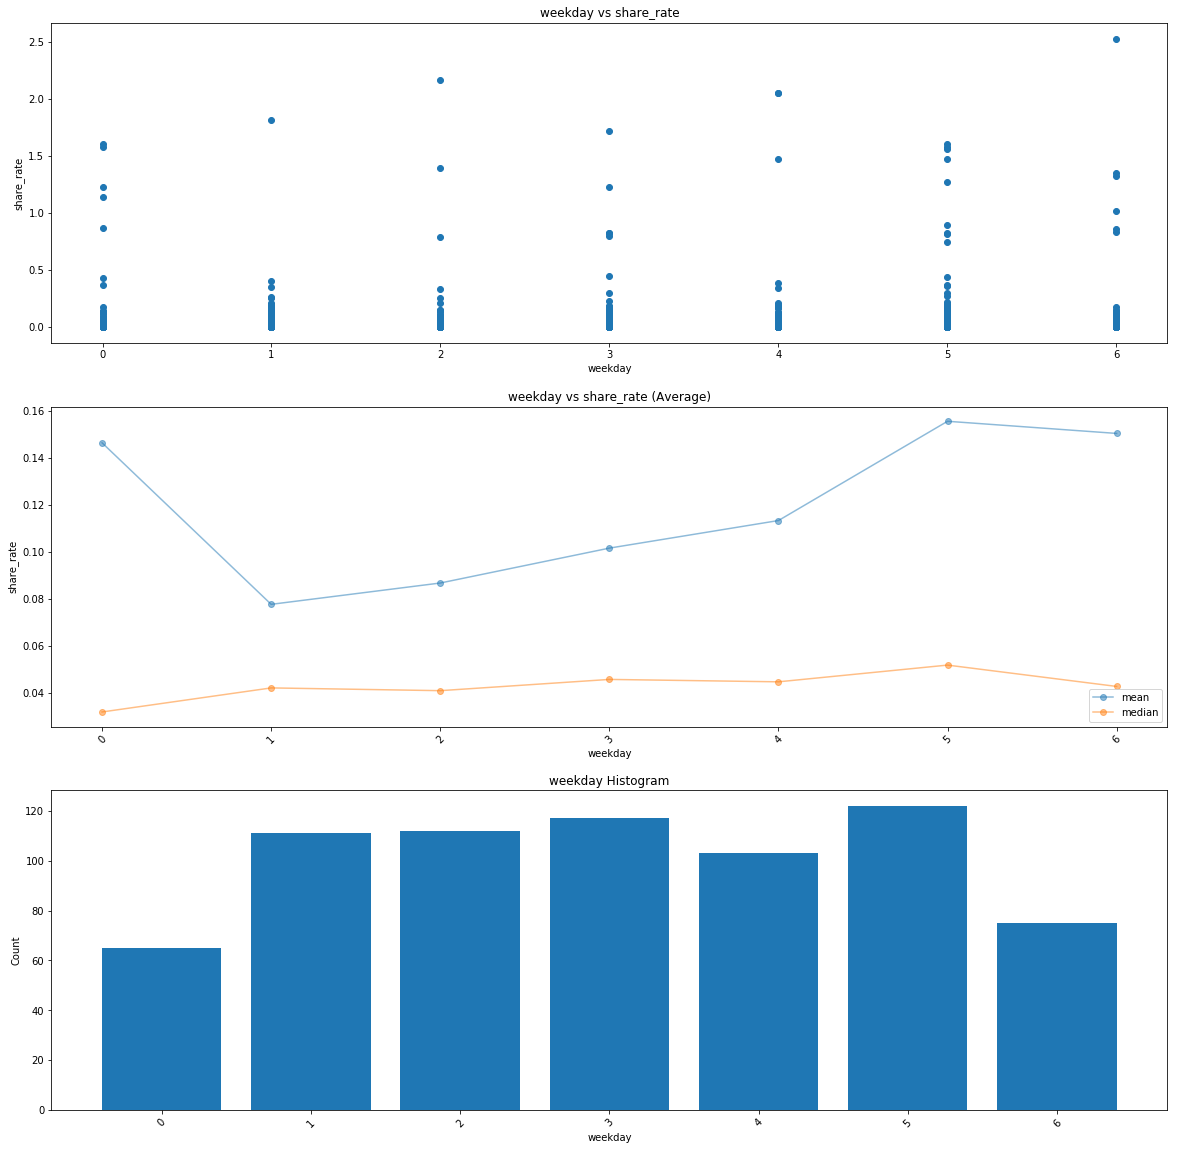

In [1642]:
plot_x_vs_y(df=df, xcol='weekday', ycols=['share_rate'])

#### Fridays are the best days to share a post, and Saturdays are the worst days to share a post

### Time

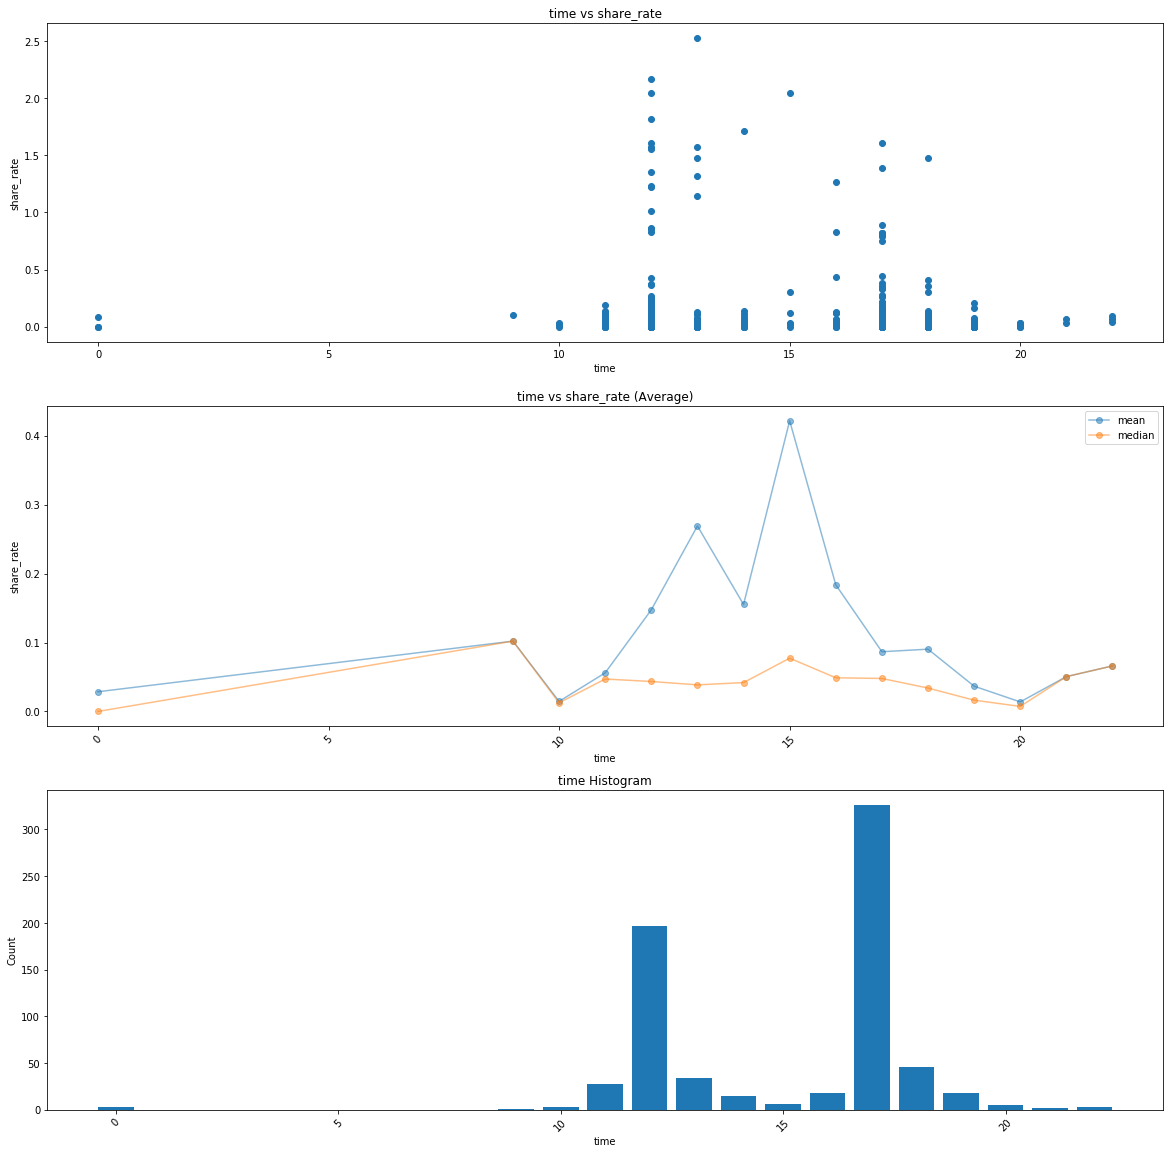

In [1643]:
plot_x_vs_y(df=df, xcol='time', ycols=['share_rate'])

#### Because of uneven frequency distribution, it is difficult to draw a conclusion

### Message Length

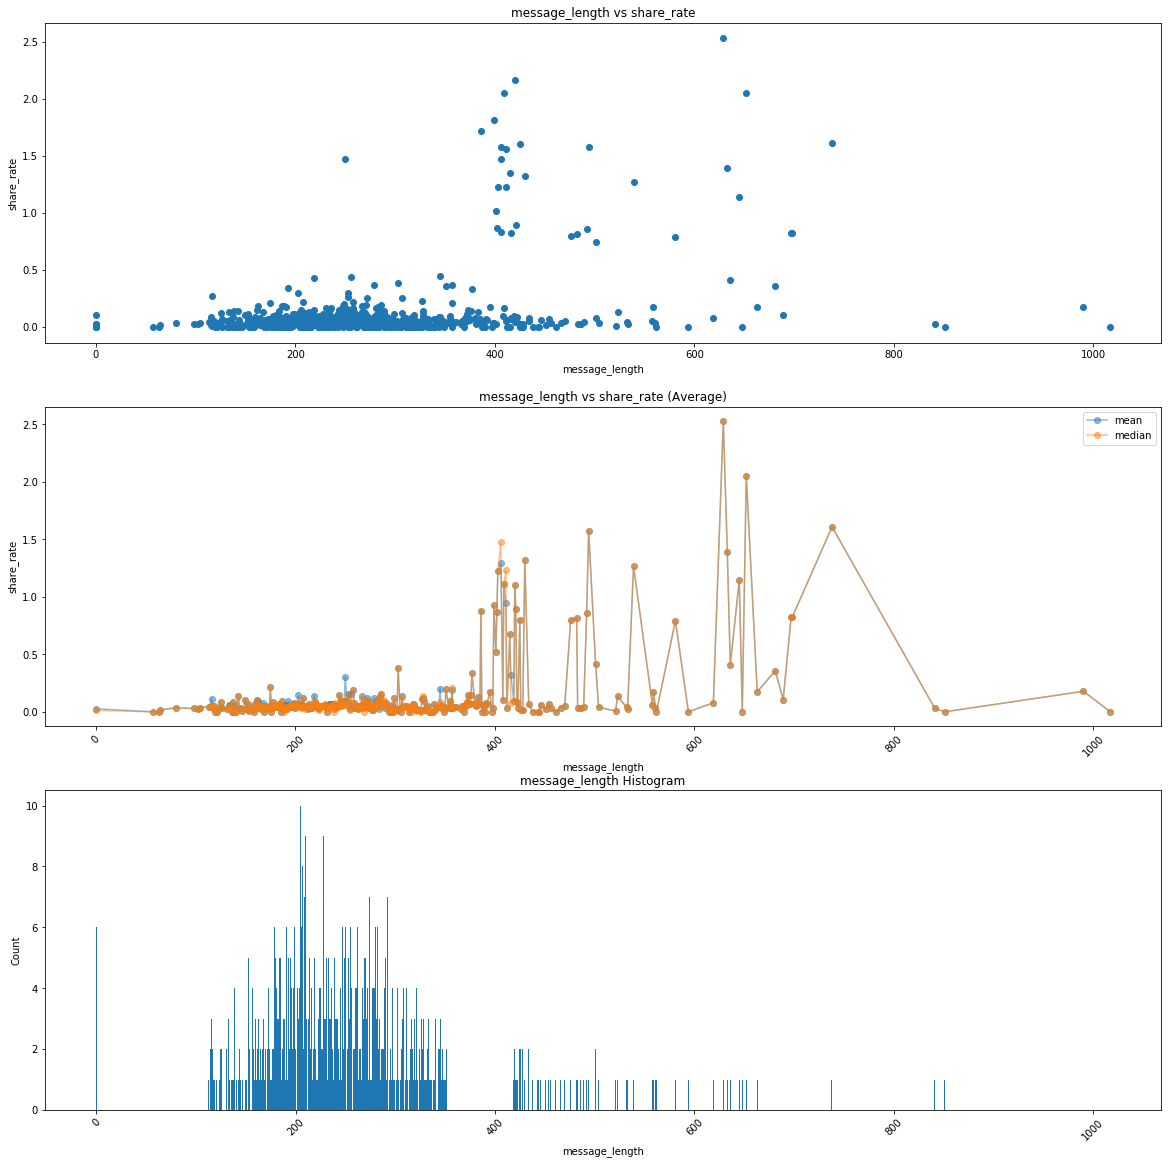

In [1644]:
plot_x_vs_y(df=df, xcol='message_length', ycols=['share_rate'])

#### Messages between the length of 400 to 700 seem to perform better. However, it is noted that contests usually contain more words in the message. So this may be an indirect result of that.

### Number of Creatives

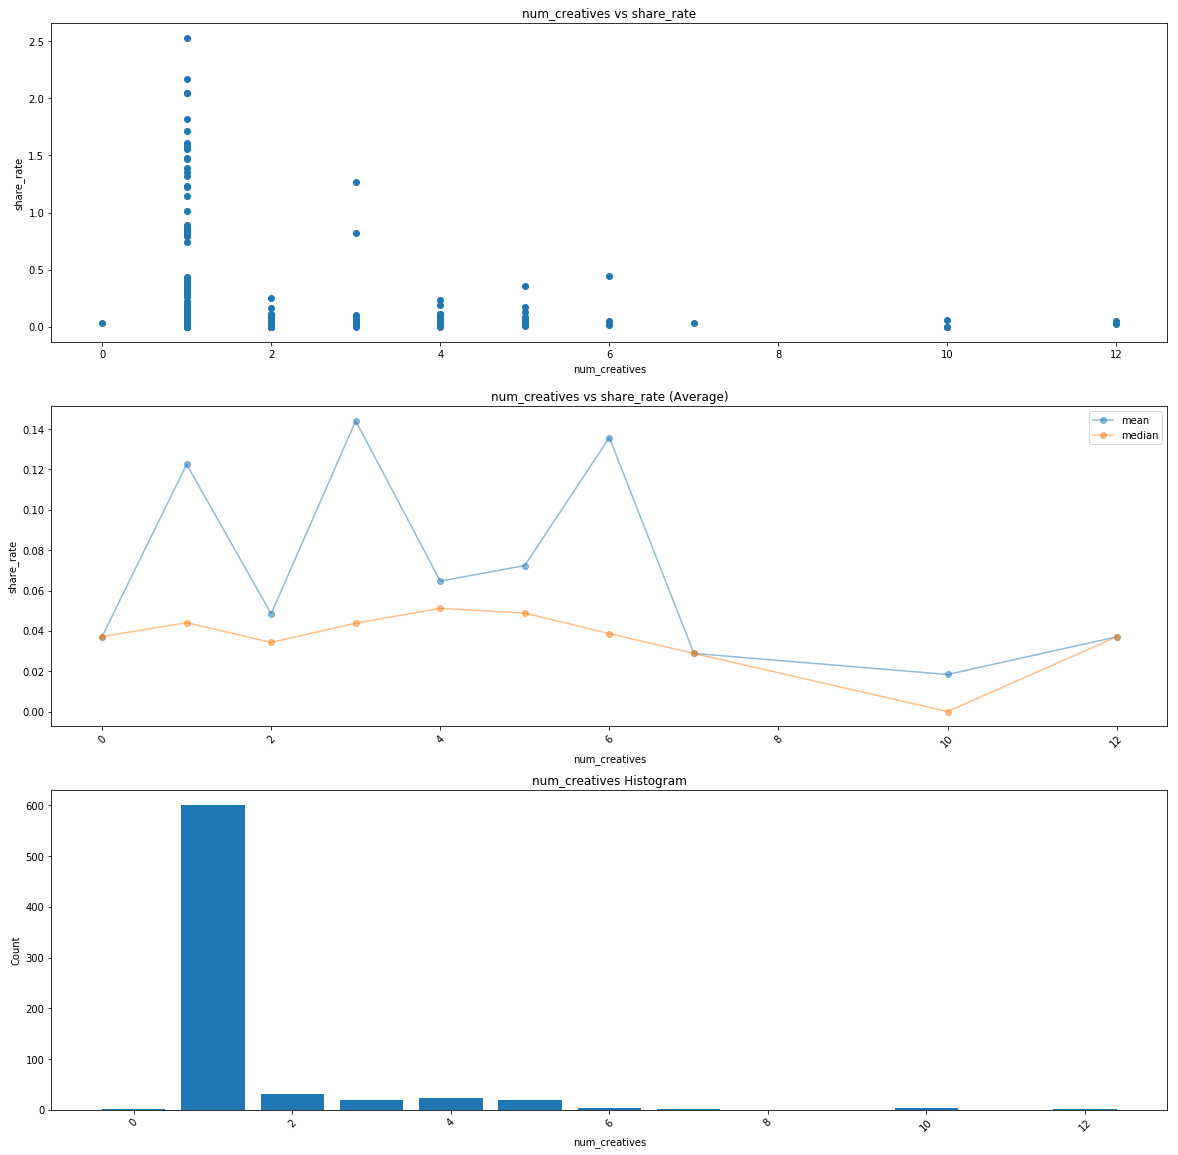

In [1645]:
plot_x_vs_y(df=df, xcol='num_creatives', ycols=['share_rate'])

#### No conclusion can be drawn here due to uneven frequency distribution

# Conclusions



- The target numbers all hover around the same number, regardless of the features. This suggests that is not a good use case for ML


- It has been debated whether neural networks can perform for regression problems. For this case, it seems like it sometimes perform better than the normal regression models, so it's inconclusive


- Data Insights:
    - A contest greatly boosts share rate
    - Paid amplification does not improve share rate significantly
    - Fridays is the best day to share a post
    - The optimal message length seems to be 400 and 700, but it is likely to be affected by other factors, so take it with a pinch of salt
    - The content within the test message affects share rate - The neural network with embeddings almost always performs better than the one without embeddings